# Covid 19 Research Clustering

### Importing libraries

In [2]:
import numpy as np
import pandas as pd 
import glob
import json
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<b> The dataset is available on "https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge/data?select=metadata.csv" </b>

In [3]:
path = "metadata.csv"

In [4]:
meta_df = pd.read_csv(path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

### Data Preparation

In [5]:
# required columns that we need for our model
dict_ = {'paper_id': meta_df['sha'] , 'doi':meta_df.doi, 'title':meta_df.title,'abstract':meta_df.abstract,'authors':meta_df.authors,'journal':meta_df.journal}

In [6]:
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi','title','abstract', 'authors', 'journal', 'abstract_summary'])

In [7]:
df_covid.fillna(value='', inplace=True)
df = df_covid.sample(5000, random_state=40)

### Vector Embeddings using TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [11]:
text = df['abstract'].values
max_features = 2**10

X1 = vectorize(text, max_features)

In [12]:
text = df['journal'].values
max_features = 2**4

X2 = vectorize(text, max_features)

In [13]:
text = df['title'].values+df['journal'].values
max_features = 2**5

X3 = vectorize(text, max_features)

In [14]:
X = X3

### Reducing the dimensionality using PCA (Principal Component Analysis)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=40)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape
#X_reduced = X

(5000, 27)

### Clustering

In [16]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans


In [17]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm

# run kmeans with many different k
distortions = []
K = range(10, 30)
for k in tqdm(K):
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.33s/it]


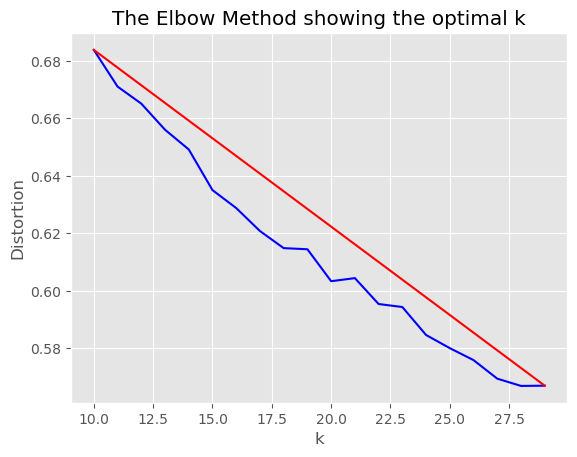

In [18]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
k = 25
kmeans = KMeans(n_clusters=k, random_state=40)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [22]:
y_pred.reshape([5000,1])

array([[ 6],
       [17],
       [ 7],
       ...,
       [19],
       [23],
       [ 1]])

### Visualization

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1,init='pca', perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 1.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.824745
[t-SNE] KL divergence after 1000 iterations: 1.227445


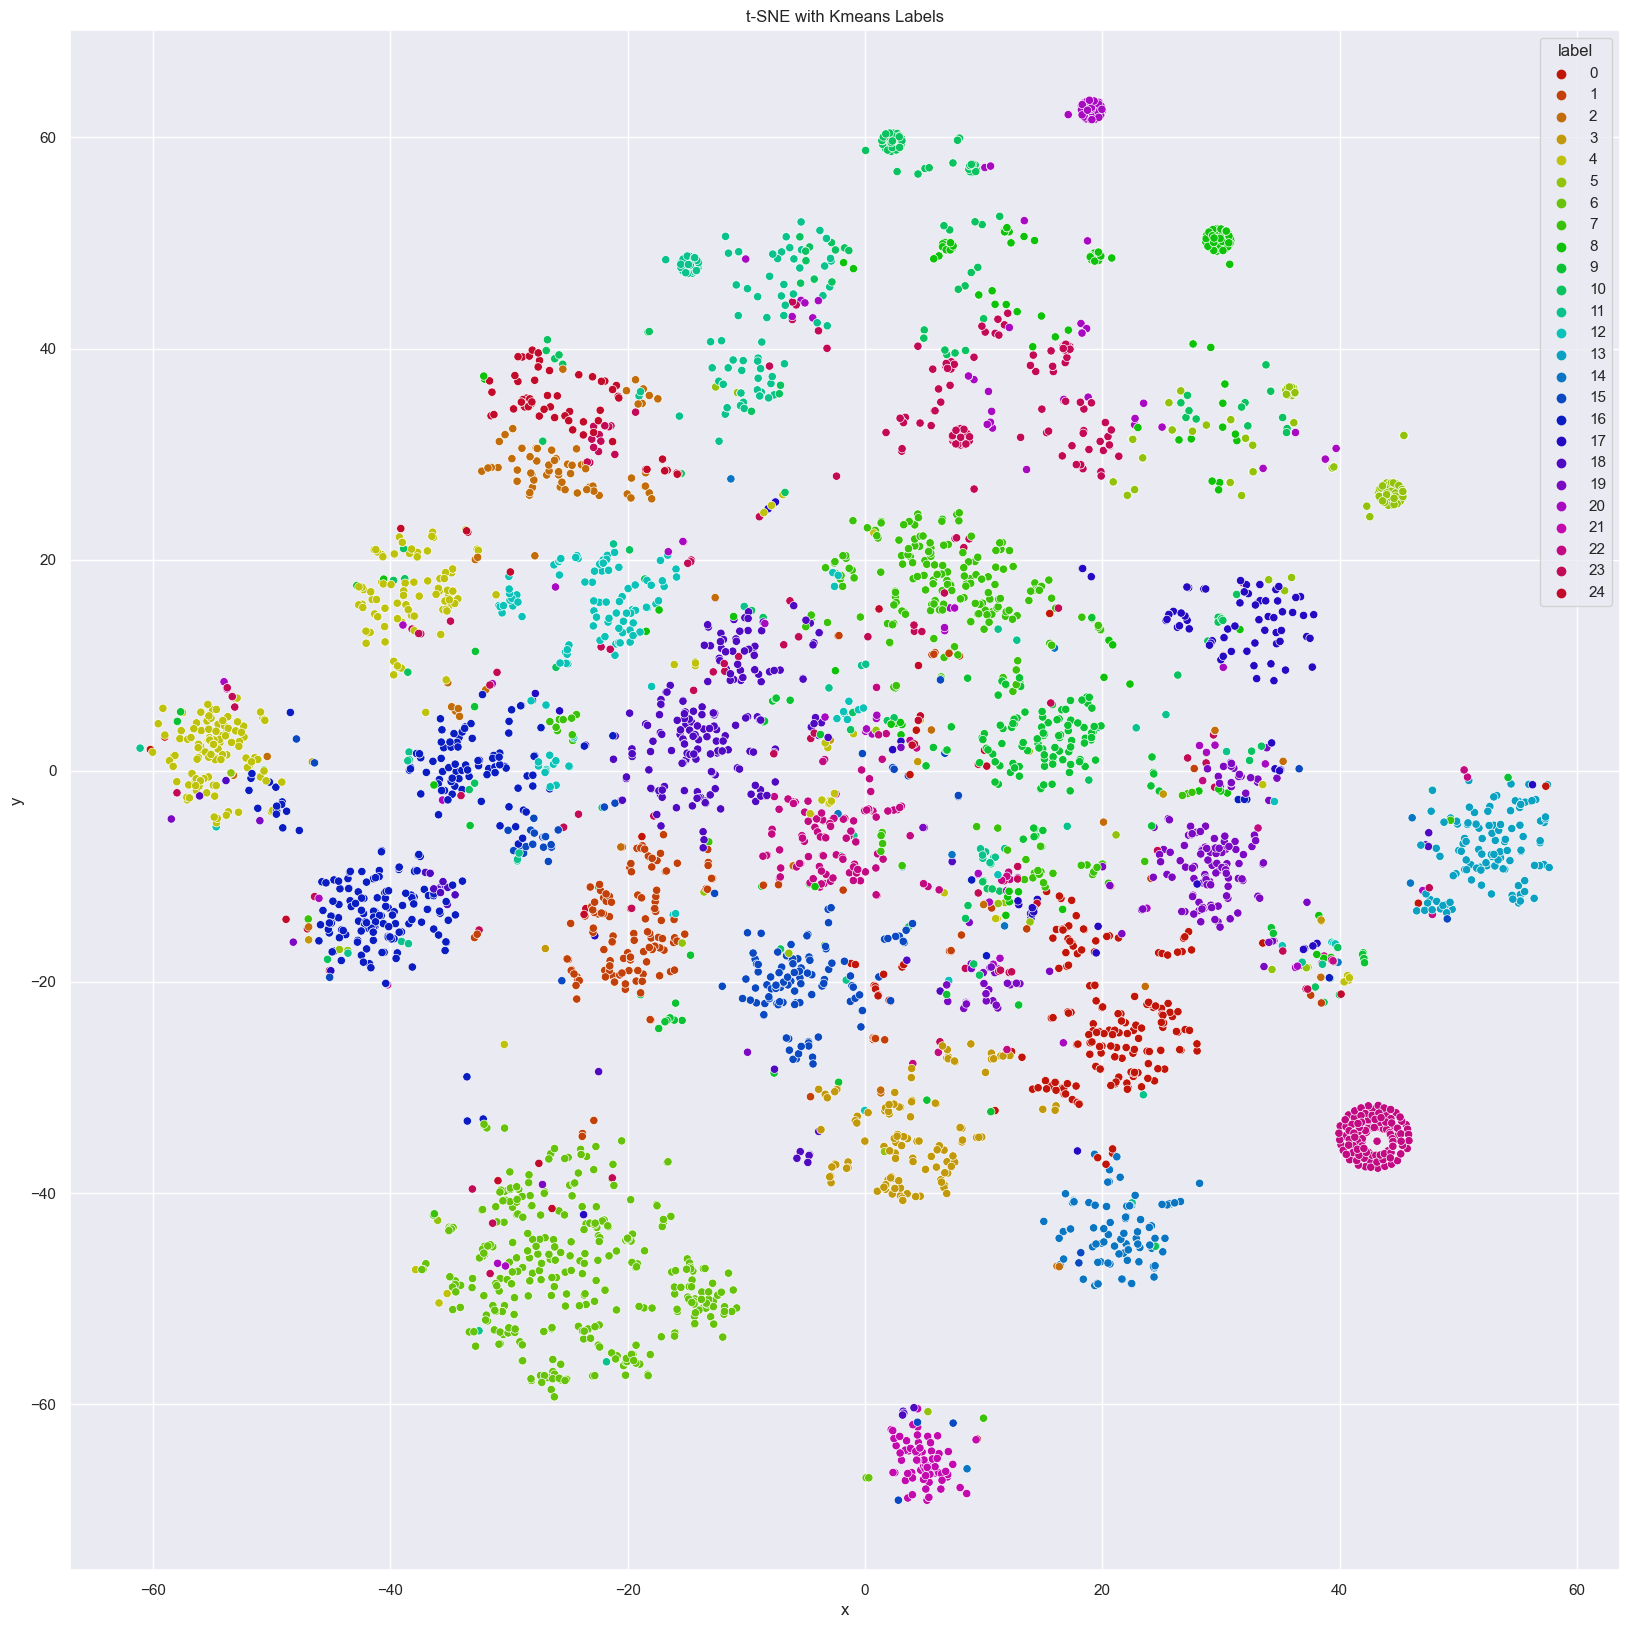

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(20,20)})

# colors
palette = sns.hls_palette(25, l=.4, s=.9)

# create a DataFrame from the data
df = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'label': y_pred
})

# plot
sns.scatterplot(data=df, x='x', y='y', hue='label', legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
#plt.savefig("improved_cluster_tsne.png")
plt.show()

<b> This map shows that our Kmeans clustering has performed very well. </b>